In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *
import dunestyle.matplotlib as dunestyle

plt.rcParams.update({
                     'figure.figsize': [8,6],
                     'xtick.labelsize': 'x-large',
                     'ytick.labelsize': 'x-large',
                     'figure.autolayout': True,
                     })
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from PIDA_class import PIDA

from pida_functions import *

DUNE plot style enabled


In [2]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df

df = loaddata("/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new_full_extra.root")
# df = pl.scan_parquet("/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new.parquet")
# df = pl.scan_parquet("data/pida_new_full.parquet")

/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new_full_extra.root loaded parquet


In [3]:
dfall = df.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity')*pl.col('trkcompleteness'),
)
dfmu = dfall.sort('trklen').filter(
    True,
    pl.col('trkPFPIsTrack'),
).group_by(selection_events()).agg(
    pl.all().last(),
).filter(
    pl.col('trkg4pdg').abs()==13,
    pl.col('trkg4mother')==0,
    pl.col('trklen')>0,
).sort('pnc').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)


In [4]:
from scipy.interpolate import interp1d
Range_grampercm = np.array([9.833E-1, 1.786E0, 3.321E0,
       6.598E0, 1.058E1, 3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
       2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3, 1.758E3, 2.297E3,
       4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4,
       4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])
KE_MeV = np.array([ 10, 14,
       20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
       4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
       200000, 300000, 400000 ])
KE_GeV = KE_MeV/1e3
mu_mom = np.sqrt(KE_GeV*(KE_GeV+2*0.1057))
binsx=np.logspace(-2,2,200)
binsy=np.logspace(-1,3.5,200)
MuMomentum2Range = interp1d(mu_mom, Range_grampercm/1.4, 'cubic')

# plt.scatter(mu_mom,Range_grampercm/1.4, c='red')

# x = np.logspace(-1, 2, 200)
# y = MuMomentum2Range(x)
# plt.plot(x, y)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Muon Momentum (GeV)')
# plt.ylabel('Drifted path length (cm)')
# csda = [plt.Line2D([0], [0], color='red', lw=2)]
# plt.legend(csda, ['CSDA Table'], loc='upper left')

In [5]:
dfmu = dfmu.with_columns(
        E = (pl.col('lepen')),
        p = (pl.col('lepen')**2 + pl.col('lepmass')**2).sqrt(),
        # Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>-1).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        pllhd = pl.when(pl.col("trkmomllhd")>-1).then(pl.col("trkmomllhd")).otherwise(0.),
        pchi2 = pl.when(pl.col("trkmomchi2")>-1).then(pl.col("trkmomchi2")).otherwise(0.),
        prange = pl.col('trkmomrange_mu'),
    ).with_columns(
        explen = pl.col('p').map_elements(lambda x: MuMomentum2Range(x), return_dtype=pl.Float64),
        Ellhd = pl.when(pl.col('trkmomllhd')>0).then((pl.col('pllhd')**2  + 0.1057**2).sqrt()).otherwise(0),
        Echi2 = pl.when(pl.col('trkmomchi2')>0).then((pl.col('pchi2')**2  + 0.1057**2).sqrt()).otherwise(0),
        Erange = (pl.col('prange')**2  + 0.1057**2).sqrt(),
    ).with_columns(
        Ereco = pl.when(pl.col('trkIsContained')==1).then(pl.col('Erange')).otherwise(
            pl.col('Ellhd')
        ),
        fraclen = pl.col('trklen')/pl.col('explen')
        # Ereco2 = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
        #     # pl.when(pl.col('Echi2')>2).then(pl.col('Echi2')).otherwise(pl.col('Ellhd'))
        #     pl.when(pl.col('Echi2')>2).then(pl.max_horizontal('Echi2','Ellhd')).otherwise(pl.col('Ellhd'))
        # )
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


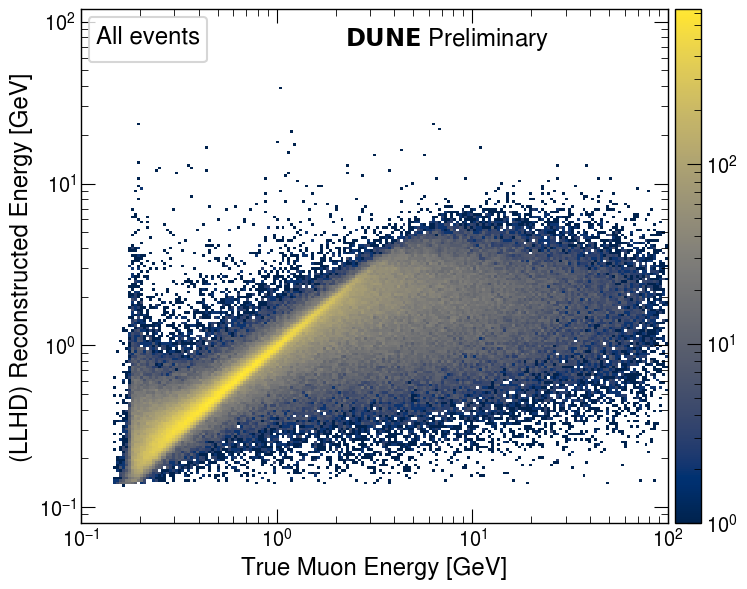

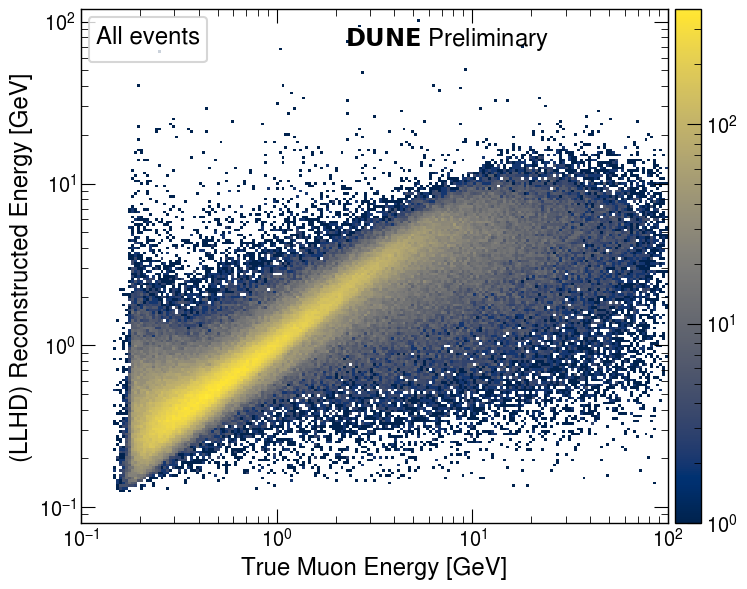

In [6]:
def plot_mu_vs_mu(Emu:pl.DataFrame,
                  label,
                  lmethod,
                  x='E',
                  y='Ereco',
                  figsize=(8,6),
                  binsx=None,
                  binsy=None,
                  ):

    fig = plt.figure(figsize=figsize)
    # binsx = np.linspace(1,10,100)
    # binsy = np.linspace(1,10,100)
    if binsx is None:
        binsx = np.logspace(-1,2,200)
    if binsy is None:
        binsy = np.logspace(-1.1,np.log10(120),200)
    fontsize='xx-large'
    plt.hist2d(Emu[x],Emu[y], bins=(binsx,binsy), norm='log', cmin=1, rasterized=True);
    # plt.plot([0,100],[0,100],'--', c='r')
    plt.xlabel('True Muon Energy [GeV]', fontsize=fontsize)
    plt.ylabel(f'{label} Reconstructed Energy [GeV]', fontsize=fontsize)

    plt.yscale('log')
    plt.xscale('log')
    # plt.tick_params(labelsize=fontsize)

    cbar = plt.colorbar(pad=0.01)
    # cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    
    if lmethod != '':
        legend = plt.legend(frameon=True, title=lmethod, loc='upper left', bbox_to_anchor=(0,0.1,1,0.9))
        plt.setp(legend.get_title(),fontsize=fontsize)
    # plt.plot([0,100],[0,100], 'r--')
    dunestyle.Preliminary(x=0.45, y=0.93, ax=plt.gca(), fontsize="xx-large")

# plot_mu_vs_mu(df,  y='Echi2', label='(Chi2)', lmethod='All events')
plot_mu_vs_mu(dfmu,  y='Ellhd', label='(LLHD)', lmethod='All events')
plot_mu_vs_mu(dfmu,  y='Echi2', label='(LLHD)', lmethod='All events')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


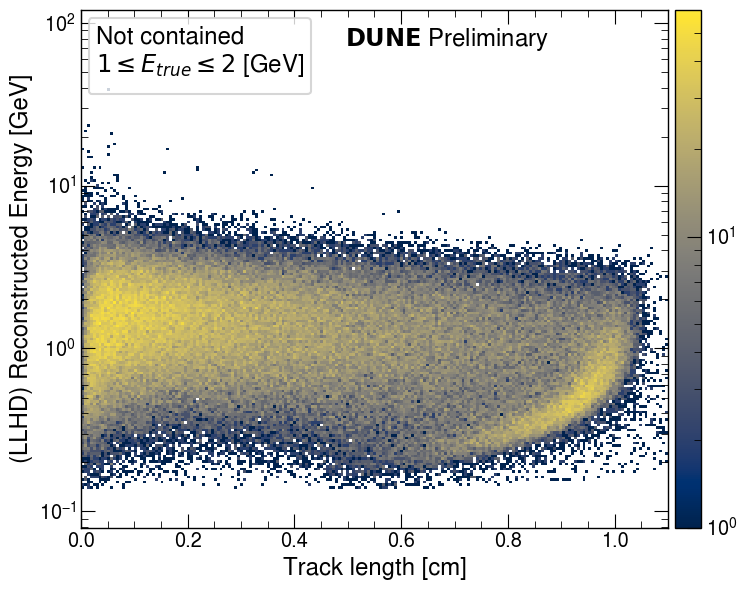

In [7]:
plot_mu_vs_mu(dfmu.filter(
                # pl.col('trkg4en').is_between(1,2),
                # pl.col('pnc')>0.5,
                # pl.col('trkIsContained'),
                ~pl.col('trkIsContained')
              ),
              # x='trklen',
              x='fraclen',
              y='Ereco',
              label='(LLHD)',
              lmethod='Not contained\n'+r'$1\leq E_{true}\leq2$ [GeV]',
              # binsx=np.logspace(np.log10(18), 3.5, 200),
              binsx=np.linspace(0, 1.1, 200),
              )
plt.xlabel('Track length [cm]')
plt.xscale('linear')

In [14]:
from scipy.stats import binned_statistic
def plot_res_scatter(x,
                    y,
                    actualx = None,
                    binsx = np.logspace(-1,2,200),
                    xlabel = 'Track length [cm]',
                    ylabel = '',
                    makefrac = True,
                    fmt='.',
                    infotype='std',
                    xscale='log',
                    yscale='linear',
                    loc='best',
                    leg_ancor=None,
                    title='',
                    xpre = 0,
                    ypre = 1.02,
                    **kwargs):
    x = x.filter(y>0)
    plotx = x.to_numpy()
    if not actualx is None:
        plotx = actualx.filter(y>0)
        plotx = plotx.to_numpy()
    y = y.filter(y>0)
    if makefrac:
        ploty = (y/x-1).to_numpy()
        # ploty = (x/y-1).to_numpy()
        # plotx = plotx[y>0]
        # ploty = ploty[y>0]
    else:
        ploty = y
    if infotype=='std':
        val, _, _ = binned_statistic(plotx, ploty, manual_std, binsx)
        val*=100
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = np.array([s*100/np.sqrt(2*c-1) if c>1 else 0 for s,c in zip(std,counts)])
        yerr = np.sqrt(yerr**2 + 0**2)
        if ylabel == '':
            ylabel = r'Resolution [%]'
        # if title=='':
        #     title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(plotx, ploty, infotype, binsx)
        std, _, _ = binned_statistic(plotx, ploty, 'std', binsx)
        counts, _, _ = binned_statistic(plotx, ploty, 'count', binsx)
        val[counts<=2] = np.nan
        yerr = [s/np.sqrt(c) if c>1 else 0 for s,c in zip(std,counts)]
        if ylabel == '':
            ylabel = r'Bias'
        # if title=='':
        #     title = infotype.capitalize()
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    if 'capsize' in kwargs.keys():
        ax.errorbar(bins_center, val, xerr=(bins_width)/2, yerr=yerr, fmt=fmt, markersize=10, **kwargs)
    else:
        ax.plot(bins_center, val, fmt, **kwargs)
    plt.ylabel(ylabel,  )
    plt.xlabel(xlabel, )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    legend = plt.legend(frameon=True, fancybox=False, bbox_to_anchor=leg_ancor,title=title, loc=loc, title_fontsize='xx-large')
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.6)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    dunestyle.Preliminary(x=xpre, y=ypre, ax=plt.gca(), fontsize="xx-large")


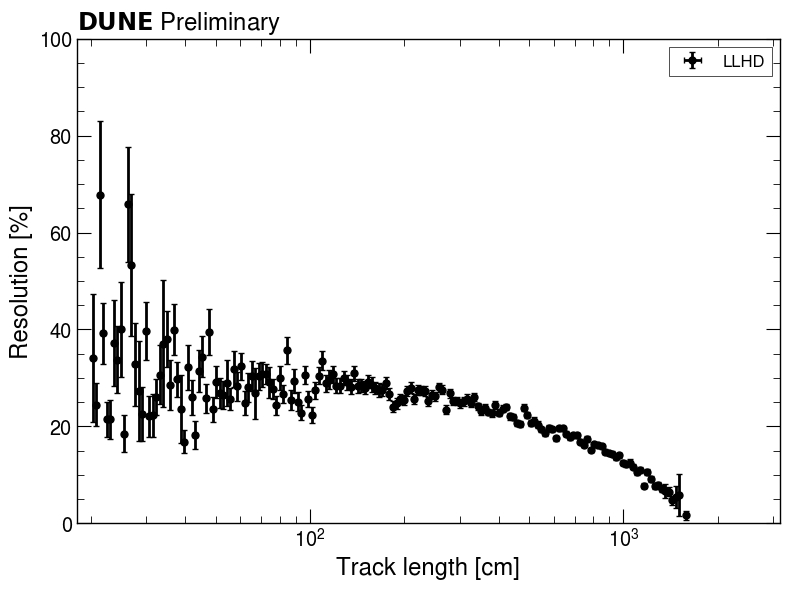

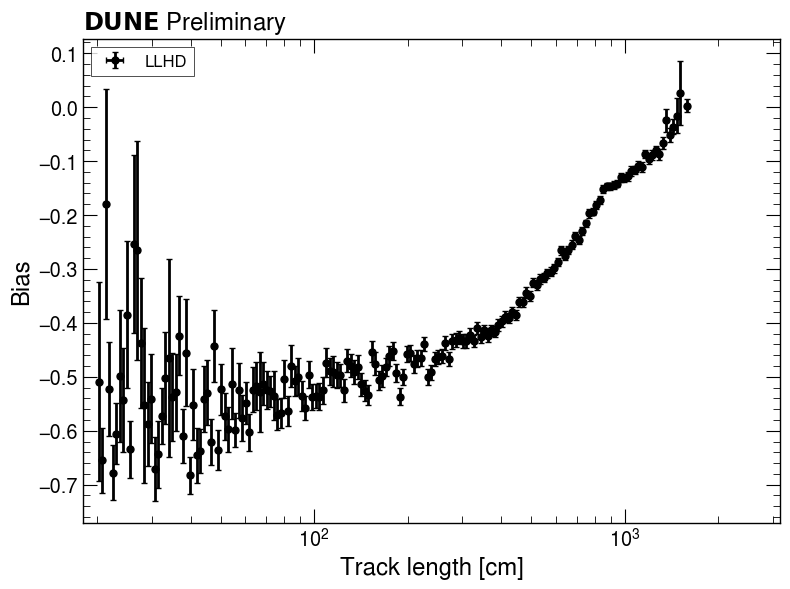

In [15]:
binsx=np.logspace(np.log10(18), 3.5, 200)
# binsx= np.logspace(-1,2,100)
xscale='log'
capsize=2
label='LLHD'
plt.figure(figsize=(8,6))
dftest = dfmu.filter(
    pl.col('trkg4en').is_between(2,4),
    ~pl.col('trkIsContained')
)
plot_res_scatter(
    dftest['trkg4en'],
    dftest['Ellhd'],
    actualx=dftest['trklen'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="LLHD",
)
plt.ylim(0,100)
plt.figure(figsize=(8,6))

plot_res_scatter(
    dftest['trkg4en'],
    dftest['Ellhd'],
    actualx=dftest['trklen'],
    xscale=xscale,
    binsx=binsx,
    capsize=capsize,
    label="LLHD",
    infotype='mean',
)

In [28]:
def quick_plot_res_bias(df,
                        x='trkg4en',
                        y='Ellhd',
                        plotx='trkstartdcos',
                        vars = ["x", "y", "z"],
                        binsx= np.linspace(-1,1,50),
                        title='LLHD',
                        xlabel='Track length [cm]',
                        xscale='linear',
                        **kwargs,
                        ):
    plt.figure(figsize=(8,6))
    capsize=2
    _xlabel=xlabel
    theargs = dict(
        x=df[x],
        y=df[y],
        xscale=xscale,
        binsx=binsx,
        capsize=capsize,
        title=title,
        xlabel=_xlabel,
        **kwargs
    )
    for i, v in enumerate(vars):
        if xlabel is None:
            _xlabel = rf'$P_{v}/P$'
        plot_res_scatter(
            actualx=df[f'{plotx}{v}'],
            label=v.upper(),
            **theargs,
        )
    plt.ylim(36,60)
    plt.savefig(f"./pdf/ereco_res_direction_{title}.pdf", dpi=200)
    plt.figure(figsize=(8,6))

    for i, v in enumerate(vars):
        plot_res_scatter(
            actualx=df[f'{plotx}{v}'],
            label=v.upper(),
            infotype='mean',
            **theargs,
        )
    plt.ylim(-.50, .17)
    plt.savefig(f"./pdf/ereco_bias_direction_{title}.pdf", dpi=200)
dftest = dfmu.filter(
    # pl.col('trkg4en').is_between(1,2),
    ~pl.col('trkIsContained')
)

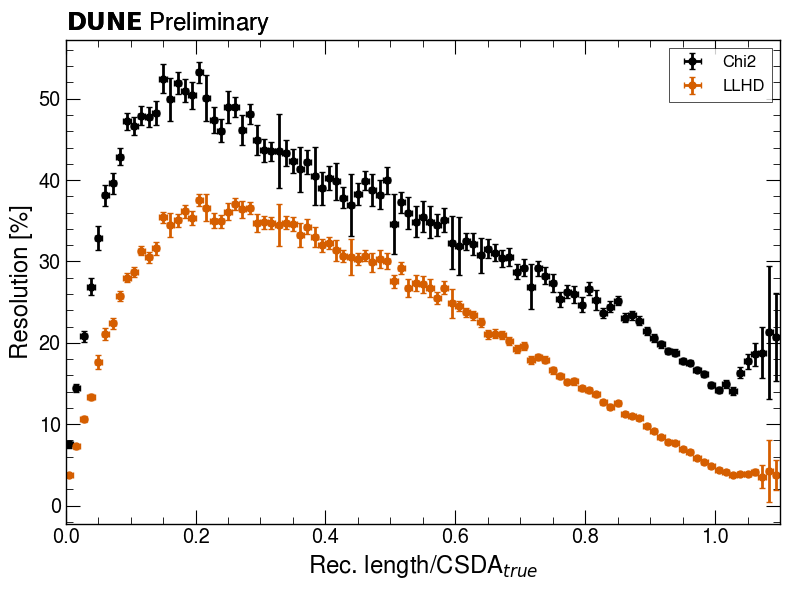

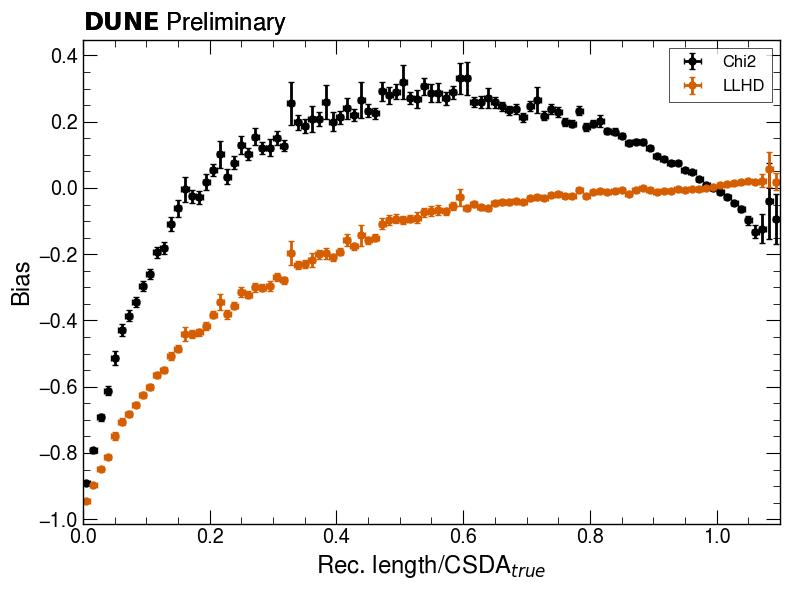

In [20]:
theargs = dict(
    x=dftest['trkg4en'],
    actualx=dftest['fraclen'],
    xscale='linear',
    capsize=2,
    binsx= np.linspace(0, 1.1,100),
    xlabel=r'Rec. length/CSDA$_{true}$',
)
plt.figure(figsize=(8,6))
plot_res_scatter(title='', y=dftest['Echi2'], label='Chi2', **theargs)
plot_res_scatter(title='', y=dftest['Ellhd'], label='LLHD', **theargs)
plt.savefig("./pdf/ereco_res_relative_length.pdf", dpi=200)
plt.figure(figsize=(8,6))
plot_res_scatter(title='', y=dftest['Echi2'], label='Chi2', infotype='mean', **theargs)
plot_res_scatter(title='', y=dftest['Ellhd'], label='LLHD', infotype='mean', **theargs)
plt.savefig("./pdf/ereco_bias_relative_length.pdf", dpi=200)
# plt.ylim(None,0.55)

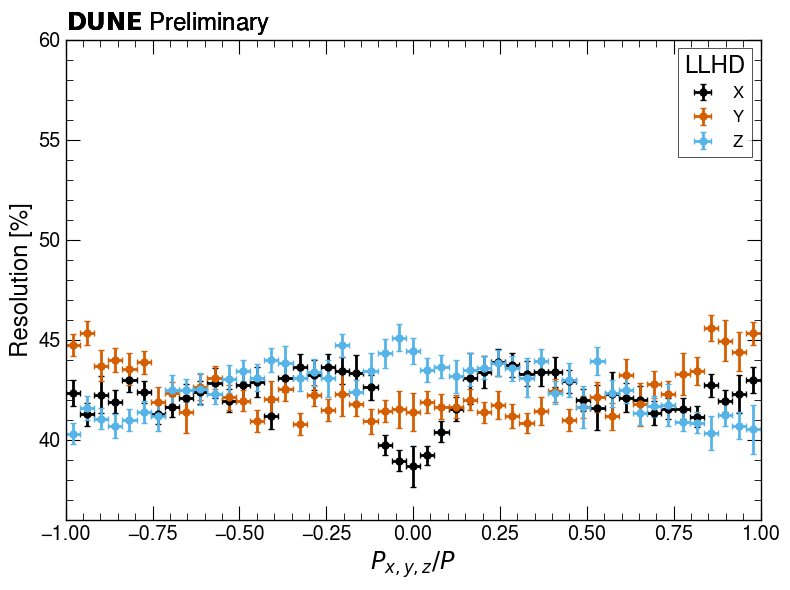

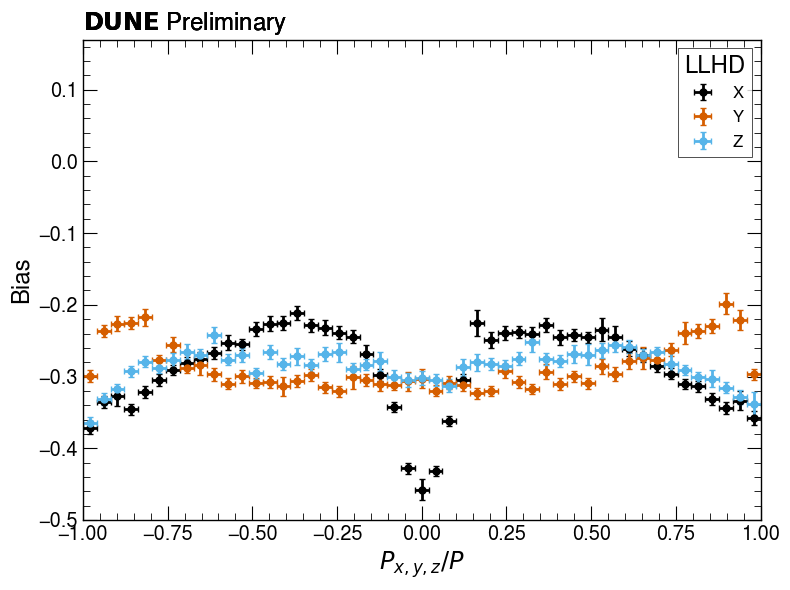

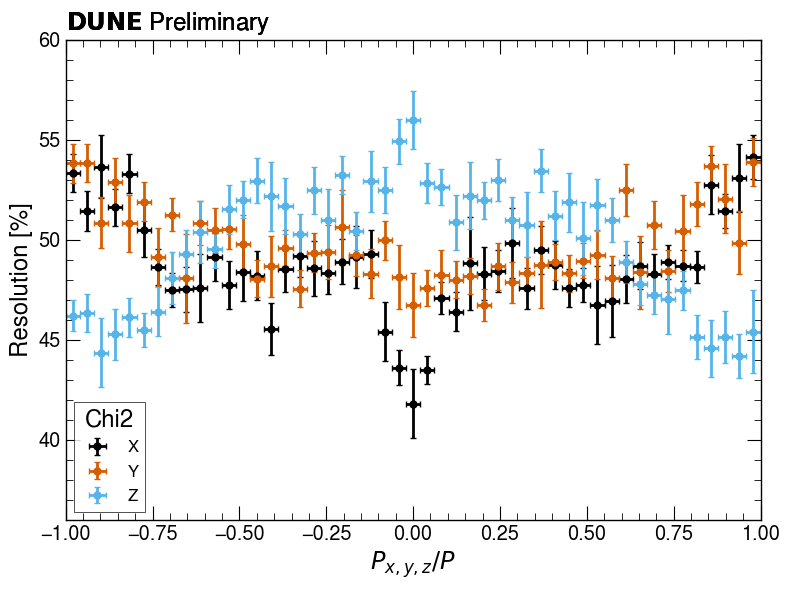

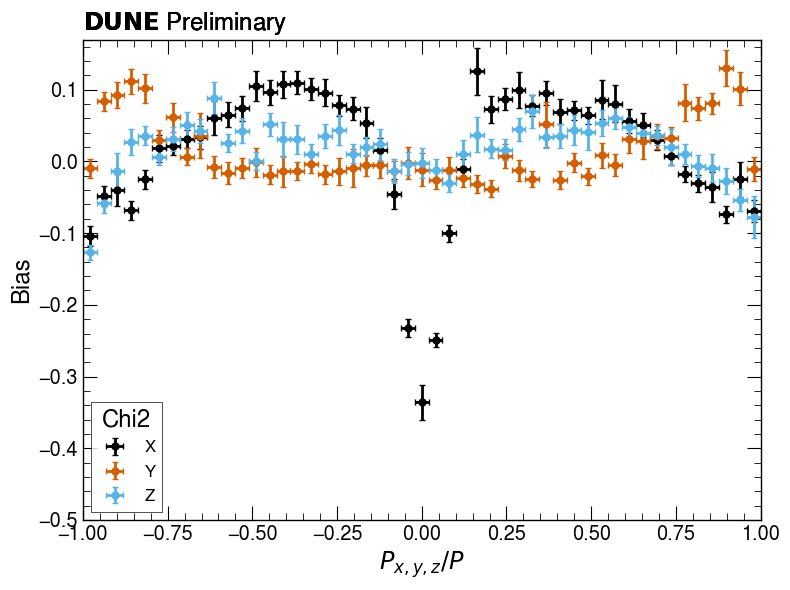

In [29]:
quick_plot_res_bias(dftest, title='LLHD', xlabel=r'$P_{x,y,z}/P$')
quick_plot_res_bias(dftest, y='Echi2', title='Chi2', xlabel=r'$P_{x,y,z}/P$')